Capstone 20.1 – Initial Report & EDA
Research Question: Predict short-term musculoskeletal injury risk using training load, movement, and recovery signals.
Dataset: Multimodal athlete monitoring dataset (5,430 rows, 31 columns).
Key EDA Note: Injuries are ~5% of the dataset, so we emphasize recall and PR-AUC.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score


In [2]:
df = pd.read_csv("/content/sports_multimodal_data.csv")

print("Shape:", df.shape)
df.head()


Shape: (5430, 31)


,heart_rate,emg_amplitude,skin_temp,gsr,respiratory_rate,spo2,bp_systolic,bp_diastolic,fatigue_index,acceleration,...,ambient_temp,humidity,heat_index,training_duration,previous_injury_history,rest_period,repetition_count,workload_intensity,acc_rms,injury_risk
0,74.967142,0.306745,33.154617,0.065939,17.977078,97.246223,117.657793,80.109155,54.831785,-0.718127,...,21.009398,24.789760,25.855921,62.680175,0,5.117926,31,4.754003,0.904436,0
1,68.617357,0.279614,33.035970,0.385663,11.316872,99.553279,124.918440,80.260665,59.224133,1.942509,...,18.718507,34.465135,28.447909,68.193399,0,6.045622,27,4.704938,1.184699,0
2,76.476885,0.134006,31.874060,0.339236,19.038077,98.053515,114.198061,88.185059,47.614986,0.567535,...,16.446042,77.616889,36.372307,89.855417,1,7.266212,36,5.687716,0.900029,0
3,85.230299,0.679033,32.550676,0.162285,14.772505,98.930086,124.997166,78.376715,36.039562,-2.097921,...,15.027612,34.447985,9.636166,69.332707,0,9.578920,27,6.770770,1.146620,0
4,67.658466,0.336259,33.003275,0.278293,14.371073,98.232013,117.869898,87.285347,55.066480,1.207819,...,25.860483,71.415446,28.544690,119.589317,0,6.276707,28,-0.172192,0.900294,0


In [3]:
df.info()
df.isna().sum().sort_values(ascending=False).head(15)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430 entries, 0 to 5429
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   heart_rate               5430 non-null   float64
 1   emg_amplitude            5430 non-null   float64
 2   skin_temp                5430 non-null   float64
 3   gsr                      5430 non-null   float64
 4   respiratory_rate         5430 non-null   float64
 5   spo2                     5430 non-null   float64
 6   bp_systolic              5430 non-null   float64
 7   bp_diastolic             5430 non-null   float64
 8   fatigue_index            5430 non-null   float64
 9   acceleration             5430 non-null   float64
 10  angular_velocity         5430 non-null   float64
 11  body_orientation         5430 non-null   float64
 12  ground_reaction_force    5430 non-null   float64
 13  step_count               5430 non-null   int64  
 14  cadence                 

,0
heart_rate,0
emg_amplitude,0
skin_temp,0
gsr,0
respiratory_rate,0
spo2,0
bp_systolic,0
bp_diastolic,0
fatigue_index,0
acceleration,0


In [4]:
df["injury_risk"].value_counts()


,count
injury_risk,
0,5160
1,270


In [5]:
print("Duplicate rows:", df.duplicated().sum())


Duplicate rows: 0


In [6]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
heart_rate,5430.0,70.020682,9.947648,37.587327,63.380668,70.071208,76.614017,109.262377
emg_amplitude,5430.0,0.546094,0.257870,0.100048,0.326396,0.542621,0.767588,0.999706
skin_temp,5430.0,33.008845,1.492605,27.116400,32.005512,33.011805,34.003980,38.143366
gsr,5430.0,0.279551,0.129870,0.050022,0.167967,0.281142,0.391472,0.499955
respiratory_rate,5430.0,15.951653,2.955197,4.430874,13.901322,15.991920,17.959894,26.834050
spo2,5430.0,97.994149,0.999271,94.467182,97.308670,97.999610,98.680309,101.691625
bp_systolic,5430.0,119.775922,12.271519,66.412754,111.338549,119.676402,128.166929,164.734000
bp_diastolic,5430.0,80.081034,7.864167,52.415657,74.667551,80.167170,85.375101,106.367236
fatigue_index,5430.0,50.156254,9.913094,7.046090,43.537513,50.179794,56.922337,85.365317
acceleration,5430.0,-0.009271,1.006589,-3.317318,-0.686116,-0.018379,0.666043,3.401876


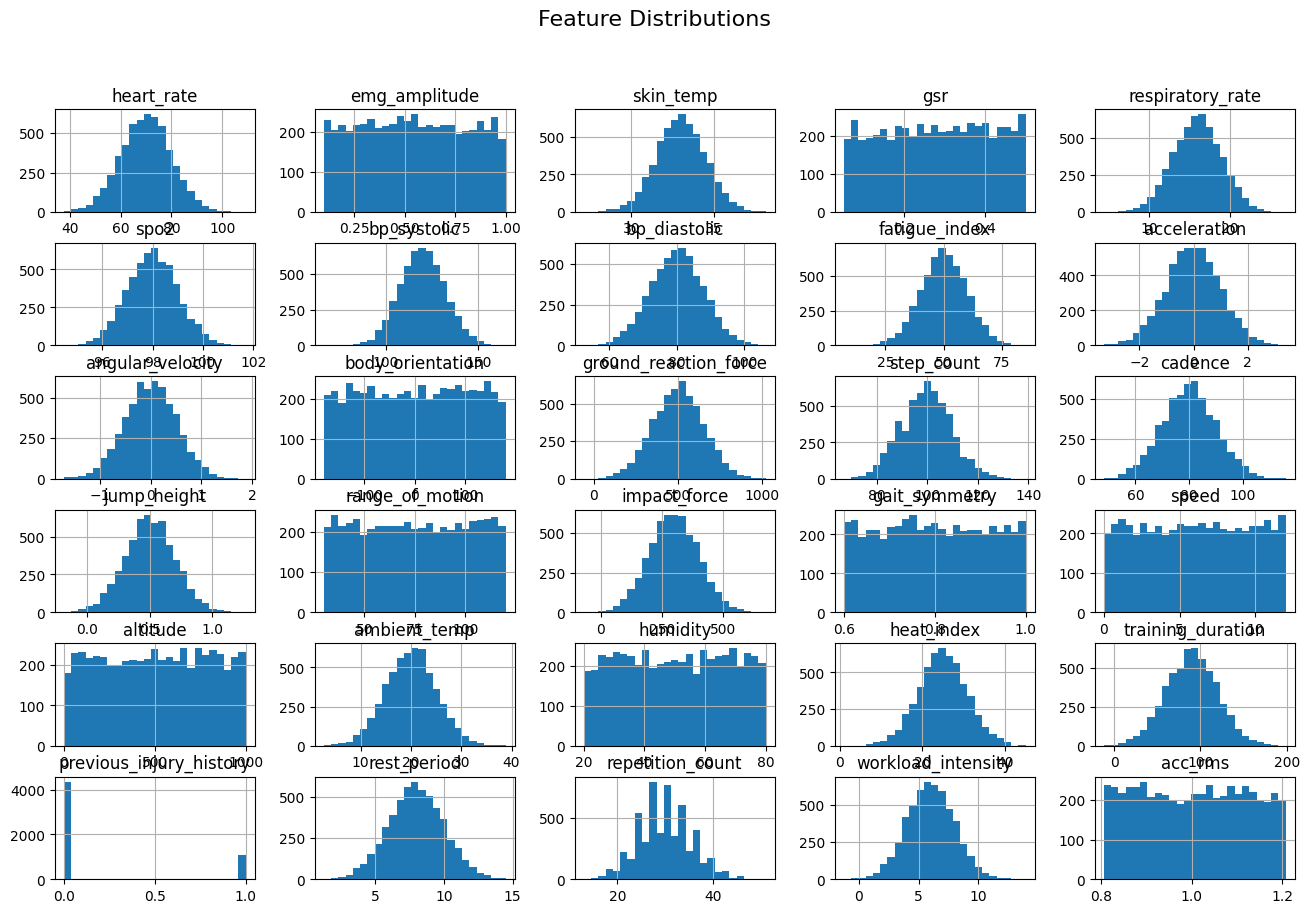

In [7]:
df.drop(columns=["injury_risk"]).hist(figsize=(16,10), bins=25)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


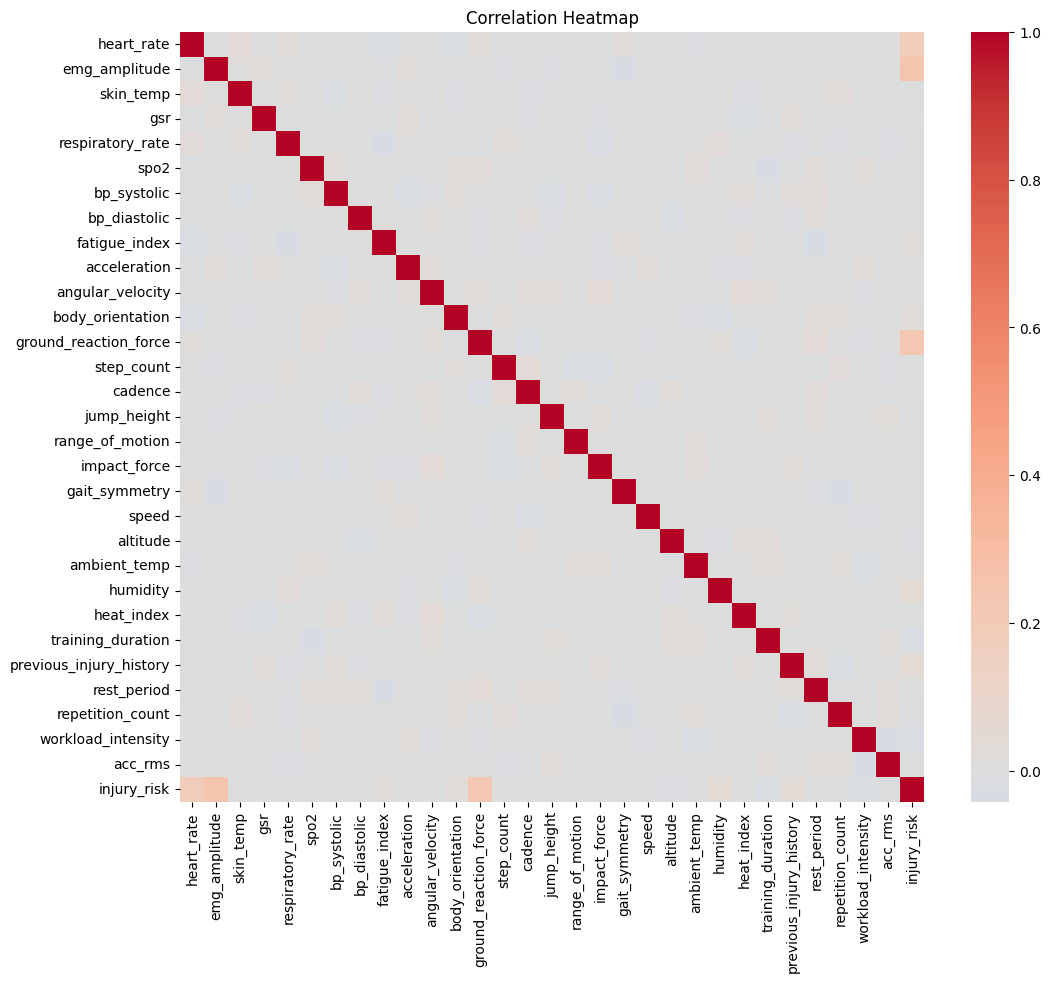

In [8]:
plt.figure(figsize=(12,10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


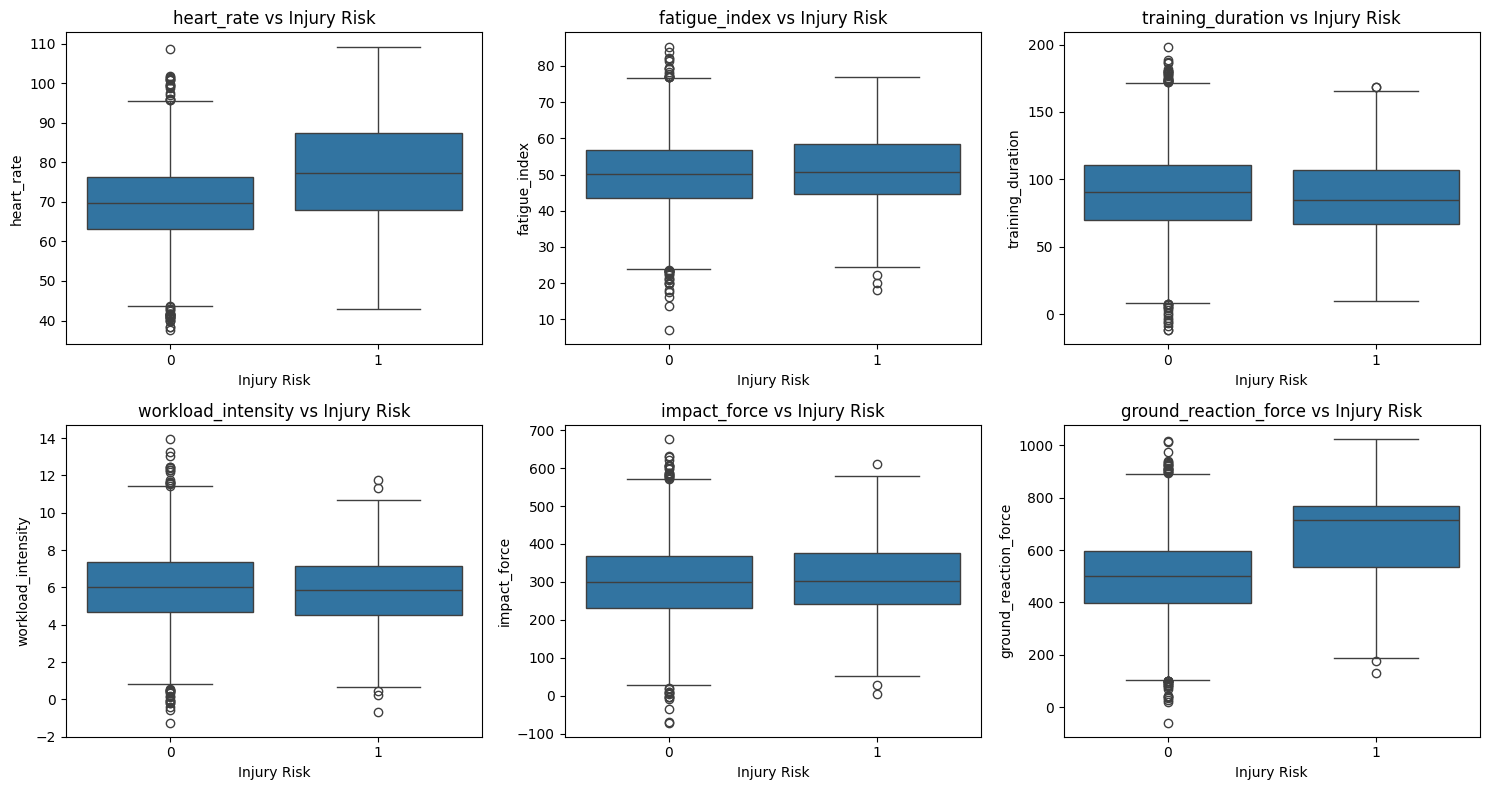

In [9]:
key_features = [
    "heart_rate",
    "fatigue_index",
    "training_duration",
    "workload_intensity",
    "impact_force",
    "ground_reaction_force"
]

plt.figure(figsize=(15,8))
for i, col in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x="injury_risk", y=col)
    plt.title(f"{col} vs Injury Risk")
    plt.xlabel("Injury Risk")
plt.tight_layout()
plt.show()


In [10]:
df["injury_risk"].value_counts()


,count
injury_risk,
0,5160
1,270


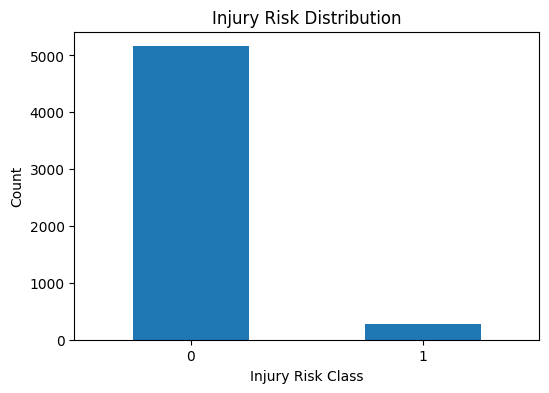

In [11]:
plt.figure(figsize=(6,4))
df["injury_risk"].value_counts().plot(kind="bar")
plt.title("Injury Risk Distribution")
plt.xlabel("Injury Risk Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


injury risk is rare (~5% of the data), so accuracy can be misleading. We will prioritize recall and PR-AUC for evaluation.

In [12]:
X = df.drop(columns=["injury_risk"])
y = df["injury_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

baseline_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"   # key for imbalance
)

baseline_model.fit(X_train_scaled, y_train)

y_pred = baseline_model.predict(X_test_scaled)
y_proba = baseline_model.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")


Confusion Matrix:
 [[896 136]
 [  6  48]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93      1032
           1       0.26      0.89      0.40        54

    accuracy                           0.87      1086
   macro avg       0.63      0.88      0.66      1086
weighted avg       0.96      0.87      0.90      1086

ROC-AUC: 0.9410
PR-AUC: 0.5325


In [13]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": baseline_model.coef_[0]
}).sort_values(by="coefficient", key=abs, ascending=False)

coef_df.head(15)


,feature,coefficient
1,emg_amplitude,2.706506
12,ground_reaction_force,1.605347
0,heart_rate,1.438122
25,previous_injury_history,0.374236
11,body_orientation,0.281599
2,skin_temp,-0.259982
7,bp_diastolic,0.257730
8,fatigue_index,0.240443
20,altitude,-0.202295
23,heat_index,0.185317
